# Projet DataMining

## Description du projet
L'objectif de ce projet est de recommander des images de pokémons en fonction des préférences de l'utilisateur. 

## Installation librairies


In [27]:
!pip install -r requirements.txt

^C


## Installation des bases de données

#### Authentification
_Pour utiliser l' API publique de Kaggle , vous devez d'abord vous authentifier à l'aide d'un jeton d'API. Depuis l'en-tête du site, cliquez sur votre photo de profil d'utilisateur, puis sur "Mon compte" dans le menu déroulant. Cela vous amènera aux paramètres de votre compte sur https://www.kaggle.com/account. Faites défiler jusqu'à la section de la page intitulée API :_

_Pour créer un nouveau jeton, cliquez sur le bouton "Créer un nouveau jeton API". Cela téléchargera un nouveau jeton d'authentification sur votre machine._

_Si vous utilisez l'outil Kaggle CLI, l'outil recherchera ce jeton dans __~/.kaggle/kaggle.json sous Linux__, OSX et d'autres systèmes d'exploitation basés sur UNIX, et dans __C:\Users<Windows-username>.kaggle\kaggle.json sous Windows__. Si le jeton n'est pas là, une erreur sera levée. Par conséquent, une fois que vous avez téléchargé le jeton, vous devez le déplacer de votre dossier Téléchargements vers ce dossier._

_Si vous utilisez directement l'API Kaggle, l'endroit où vous conservez le jeton n'a pas d'importance, tant que vous êtes en mesure de fournir vos informations d'identification au moment de l'exécution._

In [ ]:
import os
import kaggle
import shutil

In [ ]:

# Télécharger le fichier de données
kaggle.api.authenticate()
kaggle.api.dataset_download_files('kvpratama/pokemon-images-dataset', path='.', unzip=True, quiet=False, force=False)
kaggle.api.dataset_download_files('abcsds/pokemon', path='./data_csv', unzip=True, quiet=False, force=False)

100%|██████████| 70.9M/70.9M [00:19<00:00, 3.77MB/s]


100%|██████████| 14.9k/14.9k [00:00<00:00, 253kB/s]

In [ ]:
# supprimer le dossier pokemon dans pokemon_img
shutil.rmtree('./pokemon')

# Creation de la base de données

## I. Création de la base de données de pokémons

In [ ]:
from PIL import Image
import os
import json
from datetime import datetime
import numpy as np

In [ ]:
img_dir = r"./pokemon_jpg/pokemon_jpg" # chemin vers le répertoire contenant les images

# initialise un dictionnaire pour stocker les métadonnées de toutes les images
all_metadata = {}
color_data={}

In [ ]:
# boucle à travers tous les fichiers d'image dans le répertoire
for img_filename in os.listdir(img_dir):
    if img_filename.endswith(".jpg") or img_filename.endswith(".png"):
        # construire le chemin complet vers le fichier d'image
        img_path = os.path.join(img_dir, img_filename)

        # ouvrir le fichier d'image
        with Image.open(img_path) as img:

            # supprimer les images avec un nom qui ne sont pas de ce format: 1.jpg, 2.jpg, 3.jpg, etc.
            if not img_filename.split(".")[0].isdigit():
                continue

            # extraire les métadonnées de l'image
            img_filename= img.filename
            img_format = img.format
            img_size = img.size
            img_orientation = "landscape" if img_size[0] > img_size[1] else "portrait"
            creation_date =  datetime.fromtimestamp(os.path.getctime(img_path)).strftime('%d/%m/%Y')

            # créer un dictionnaire de métadonnées pour cette image
            metadata = {
                #on veut juste le nom de l'image
                "id": int((img_filename.split("\\")[-1]).split(".")[0]),
                "format": img_format,
                "size": img_size,
                "orientation": img_orientation,
                "creation_date": creation_date,
                "tags": ""
            }

            # ajouter les métadonnées de cette image au dictionnaire de toutes les métadonnées
            all_metadata[img_filename.split("\\")[-1]] = metadata

In [ ]:
# Ajouter les métadonnées au fichier JSON
with open('database.json', "w") as f:
    json.dump(all_metadata, f, indent=4)

## II. Création de la base de données de couleurs

In [ ]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
from sklearn.cluster import MiniBatchKMeans
from webcolors import CSS3_NAMES_TO_HEX, hex_to_rgb, rgb_to_hex, hex_to_name

In [ ]:
def closest_color(requested_color):
    requested_color = hex_to_rgb(requested_color)
    min_colors = {}
    for key, value in CSS3_NAMES_TO_HEX.items():
        color = hex_to_rgb(value)
        red_difference = (color[0] - requested_color[0]) ** 2
        green_difference = (color[1] - requested_color[1]) ** 2
        blue_difference = (color[2] - requested_color[2]) ** 2
        difference = red_difference + green_difference + blue_difference
        min_colors[difference] = key
    return min_colors[min(min_colors.keys())]

In [31]:
# boucle à travers tous les fichiers d'image dans le répertoire
color_data = {}
img_dir = r"./pokemon_jpg/pokemon_jpg" 
for img_filename in os.listdir(img_dir): 
    if img_filename.endswith(".jpg") or img_filename.endswith(".png"):
        # Construire le chemin complet vers le fichier d'image
        img_path = os.path.join(img_dir, img_filename)
        # Ouvrir l'image
        with Image.open(img_path) as img:
            
            
            # Supprimer les images avec un nom qui ne sont pas de ce format: 1.jpg, 2.jpg, 3.jpg, etc.
            if not img_filename.split(".")[0].isdigit():
                continue

            pixel_matrix = np.array(img) # Convertir l'image en matrice de pixels

            # Convertir la matrice de pixels en un tableau de pixels
            pixel_data = pixel_matrix.reshape((pixel_matrix.shape[0] * pixel_matrix.shape[1], 3))

            # Utiliser l'algorithme K-Means pour extraire la couleur dominante
            kmeans = MiniBatchKMeans(n_clusters=5, random_state=0).fit(pixel_data)
    

            # Extraire la couleur dominante
            dominant_color = kmeans.cluster_centers_[4]

            # Convertir la couleur dominante en hexadécimal
            hex_color = '#{:02x}{:02x}{:02x}'.format(int(dominant_color[0]), int(dominant_color[1]), int(dominant_color[2]))
            
            # Convertir la valeur hexadécimale en nom de couleur
            try:
                color_name = hex_to_name(hex_color)
            except ValueError:
                color_name = closest_color(hex_color)
            

            # créer un dictionnaire de couleur pour cette image
            color = {
                "id": int((img_filename.split("\\")[-1]).split(".")[0]),
                "nom couleur": color_name
            }

            # ajouter les couleurs de cette image au dictionnaire de toutes les couleurs
            color_data[(img_filename.split("\\")[-1]).split(".")[0]] = color


c:\Users\Tototime\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tototime\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tototime\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tototime\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set th

In [32]:
# Ajouter les couleurs au fichier JSON
with open('color_data.json', 'w') as f:
    json.dump(color_data, f, indent=4)

## III. Ajout des couleurs aux pokémons

In [33]:
# ajoute les couleurs au fichier json principal
with open('database.json', 'r') as f:
    pokemon_data = json.load(f)

with open('color_data.json', 'r') as f:
    color_data = json.load(f)

# si l'id du pokemon est le meme que l'id de la couleur, ajoute la couleur au pokemon
for pokemon in pokemon_data:
    for color in color_data:
        if pokemon_data[pokemon]['id'] == color_data[color]['id']:
            pokemon_data[pokemon]['couleur dominante'] = color_data[color]['nom couleur']

with open('database.json', 'w') as f:
    json.dump(pokemon_data, f, indent=4)


## Ajout de tags

In [34]:
import pandas as pd
import json
import csv

In [35]:
# Charger les données de tags.json dans data_d["tags"]
df = pd.read_csv(r"./data_csv/Pokemon.csv", sep=',', header=0)
df_selected = df.loc[:, ['#','Name', 'Type 1', 'Type 2', 'Generation', 'Legendary']]

In [36]:
# Renommer la colonne # en id
df_selected.rename(columns={'#': 'id'}, inplace=True)

with open('tags.json', 'w') as f:
    f.write(df_selected.to_json(orient='records')) 

with open('tags.json', 'r') as f:
    data_t = json.load(f)

with open('tags.json', 'w') as f:
    json.dump(data_t, f, indent=4)

with open('database.json', 'r') as f:
    data_d = json.load(f)

In [37]:
# Charger les données de tags.json dans data_d["tags"]
for key in data_d:
    for i in range(len(data_t)):
        if data_d[key]["id"] == data_t[i]["id"]:
            data_d[key]["tags"] = data_t[i]

#Enlever l'id de data_d["tags"]
for key in data_d:
    data_d[key]["tags"].pop("id")

# Enregistrer les données dans database.json
with open('database.json', 'w') as f:
    json.dump(data_d, f, indent=4)

## Creation des utilisateurs

In [38]:
import json
from random import randint, choice
import os

In [39]:
# Fonction de filtrage en fonction des préférences utilisateur
def filter_images(images, Type1, Type2, legendary):
    filtered_images = []
    for image in images.values():
        color = image["couleur dominante"]
        type1 = image["tags"]["Type 1"]
        type2 = image["tags"]["Type 2"]
        legendaire = image["tags"]["Legendary"]
        tags= image["tags"]
        if (type1 == Type1 or type2 == Type1) and (type1 == Type2 or type2 == Type2) and not(legendaire^legendary):
            tags["color"]=color
            filtered_images.append(tags)
    return filtered_images


In [40]:
# récuperation des nom couleurs dans database.json
data_t={}
with open("database.json", "r") as f:
    data=json.load(f)
    for i in data:
        data_t[data[i]["id"]]=data[i]

# récuperation des Types dans database.json
Type_t=[]
for i in data_t:
    if data_t[i]["tags"]["Type 1"] not in Type_t:
        Type_t.append(data_t[i]["tags"]["Type 1"])
    if data_t[i]["tags"]["Type 2"] not in Type_t:
        Type_t.append(data_t[i]["tags"]["Type 2"])

# récuperation des couleurs dans database.json
color_t=[]
for i in data_t:
    if data_t[i]["couleur dominante"] not in color_t:
        color_t.append(data_t[i]["couleur dominante"])

legendary_t=[True, False]


In [41]:
# enregistrement des données dans recommendation.json
with open("recommendation.json", "w") as f:
    json.dump({"Type":Type_t, "Color":color_t}, f, indent=4)

In [42]:
#simulation de l'utilisateur

favorite_t=["NoFavorite", "Favorite"]
all_user={}
nb_user=100
i=0

while i<nb_user:
    result=[]
    Type1=choice(Type_t) # choix du premier type
    Type2=choice(Type_t) # choix du deuxième type
    legendary=choice(legendary_t)
    data=filter_images(data_t, Type1, Type2, legendary) # filtrage des images
    if len(data)>0:
        for k in range(len(data)): # choix de favorite ou non favorite
            result.append(favorite_t[randint(0, len(favorite_t)-1)])
        all_user[i]={"data":data, "result":result}
        i+=1
    else:
        continue

    

In [43]:
pok=[]
like=[]

for i in all_user: # création d'un dictionnaire avec les données et les résultats
    for k in range(len(all_user[i]["data"])):
        pok.append(all_user[i]["data"][k])
        like.append(all_user[i]["result"][k])

user={"data":pok, "result":like}

# compter le nombre de favorite et non favorite
nb_favorite=0
nb_nofavorite=0
for i in user["result"]:
    if i=="Favorite":
        nb_favorite+=1
    else:
        nb_nofavorite+=1

print(len(user["result"]))
print("nb_favorite: ", nb_favorite)
print("nb_nofavorite: ", nb_nofavorite)

1028
nb_favorite:  526
nb_nofavorite:  502


In [44]:
# sauvegarde des données utilisateur
with open("user.json", "w") as f:
    json.dump(user, f, indent=4)

## Entrainement du modèle

## A. Decision Tree

In [10]:
from sklearn import tree
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import graphviz
import pydotplus
from IPython.display import Image, display
import json
import pickle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

In [11]:
#importer les données de l'utilisateur
with open('user.json', "r") as f:
        user=json.load(f)

In [12]:
#creation du tree
dtc = tree.DecisionTreeClassifier()

#creation des labels encoder
le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()
le5 = LabelEncoder()
le6 = LabelEncoder()

### __A.1 Création du modèle__

In [13]:
# creation des dataframes
data = user["data"]
result = user["result"]
dataframe = pd.DataFrame(data, columns=["Type 1", "Type 2", "Generation","legendary", "color"])
resultframe = pd.DataFrame(result, columns=["favorite"])

# encoding des données
dataframe["Type 1"] = le1.fit_transform(dataframe["Type 1"])
dataframe["Type 2"] = le2.fit_transform(dataframe["Type 2"])
dataframe["Generation"] = le3.fit_transform(dataframe["Generation"])
dataframe["legendary"] = le4.fit_transform(dataframe["legendary"])
dataframe["color"] = le5.fit_transform(dataframe["color"])
resultframe["favorite"] = le6.fit_transform(resultframe["favorite"])
# creation du model
dtc.fit(dataframe, resultframe)



DecisionTreeClassifier()

### __A.2 Visualisation du modèle__

In [49]:
# Visualisation du modele 
dot_data = tree.export_graphviz(
    dtc,
    out_file=None,
    feature_names=dataframe.columns,
    filled=True,
    rounded=True,
    class_names=le6.inverse_transform(resultframe.favorite.unique()),
    special_characters=True,
)
graph = graphviz.Source(dot_data)

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
img = Image(pydot_graph.create_png())
display(img)

### __A.3 Evaluation du modèle__

In [14]:
# precision du modele
print("Accuracy:",metrics.accuracy_score(resultframe, dtc.predict(dataframe)))

# score F1 du modele
print("F1 score:",metrics.f1_score(resultframe, dtc.predict(dataframe)))


Accuracy: 0.8142023346303502
F1 score: 0.7921653971708378


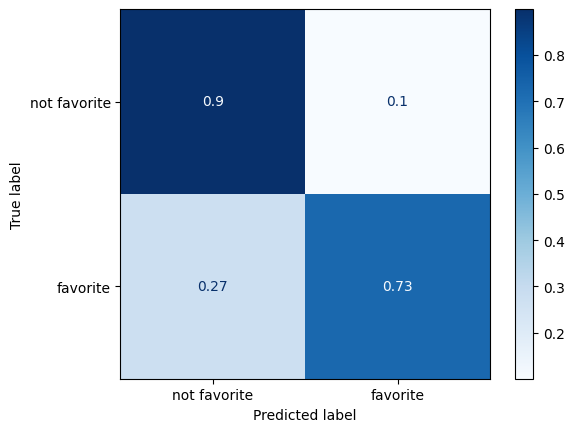

In [51]:
# prediction du modele
y_pred = dtc.predict(dataframe)

# creating confusion matrix
cm = confusion_matrix(resultframe, y_pred, normalize='true')
    
# displaying confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not favorite', 'favorite'])
disp.plot(cmap='Blues')
plt.show()

### __Sauvegarde du modèle__

In [52]:
pickle.dump(dtc, open("decision_tree.pkl", "wb"))

## B. Neural Network

### __B.1 Creation du modèle__

In [53]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
import json
import matplotlib.pyplot as plt
import pickle
from ann_visualizer.visualize import ann_viz

In [54]:
# importation des données utilisateur
with open('user.json', 'r') as f:
    user_data = json.load(f)

In [55]:
le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()
le5 = LabelEncoder()
le6 = LabelEncoder()

In [56]:
# creation des dataframes
data = user_data["data"]
result = user_data["result"]
dataframe = pd.DataFrame(data, columns=["Type 1", "Type 2", "Generation","legendary", "color"])
resultframe = pd.DataFrame(result, columns=["favorite"])

# encoding des données
dataframe["Type 1"] = le1.fit_transform(dataframe["Type 1"])
dataframe["Type 2"] = le2.fit_transform(dataframe["Type 2"])
dataframe["Generation"] = le3.fit_transform(dataframe["Generation"])
dataframe["legendary"] = le4.fit_transform(dataframe["legendary"])
dataframe["color"] = le5.fit_transform(dataframe["color"])
resultframe["favorite"] = le6.fit_transform(resultframe["favorite"])

# Separe les données en données d'entrainement et de test
train_dataset = dataframe.sample(frac=0.8, random_state=0)
test_dataset = dataframe.drop(train_dataset.index)

# Separe les labels en labels d'entrainement et de test
train_labels = resultframe.sample(frac=0.8, random_state=0)
test_labels = resultframe.drop(train_labels.index)

# Definie le modele
model = Sequential()
model.add(Dense(64, input_dim=5, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilation du modele
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# entrainement du modele
history = model.fit(train_dataset, train_labels, validation_data=(test_dataset, test_labels), epochs=50) # epochs= nombre d'itération


Epoch 1/50
26/26 [==============================] - 1s 11ms/step - loss: 0.8004 - accuracy: 0.5024 - val_loss: 0.7122 - val_accuracy: 0.4806
Epoch 2/50
26/26 [==============================] - 0s 3ms/step - loss: 0.7092 - accuracy: 0.5036 - val_loss: 0.6957 - val_accuracy: 0.4951
Epoch 3/50
26/26 [==============================] - 0s 3ms/step - loss: 0.7054 - accuracy: 0.5024 - val_loss: 0.7030 - val_accuracy: 0.5146
Epoch 4/50
26/26 [==============================] - 0s 2ms/step - loss: 0.6933 - accuracy: 0.5426 - val_loss: 0.6957 - val_accuracy: 0.5243
Epoch 5/50
26/26 [==============================] - 0s 3ms/step - loss: 0.6908 - accuracy: 0.5255 - val_loss: 0.7116 - val_accuracy: 0.4854
Epoch 6/50
26/26 [==============================] - 0s 3ms/step - loss: 0.6950 - accuracy: 0.5389 - val_loss: 0.7226 - val_accuracy: 0.5146
Epoch 7/50
26/26 [==============================] - 0s 3ms/step - loss: 0.7075 - accuracy: 0.5219 - val_loss: 0.7512 - val_accuracy: 0.4757
Epoch 8/50
26/26 [=

### __B.2 Visualisation du modèle__

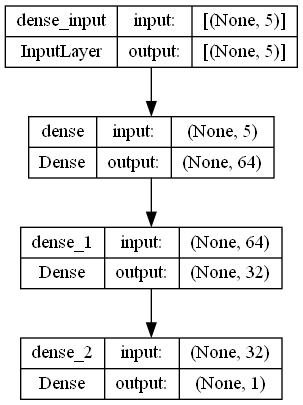

In [57]:
# visualisation du modele
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
ann_viz(model, title="Neural Network Model for Favorite Pokemon", view=True)

### __B.3 Evaluation du modèle__

In [58]:
# Evaluation du modele
test_loss, test_acc = model.evaluate(train_dataset, train_labels)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

26/26 [==============================] - 0s 2ms/step - loss: 0.6649 - accuracy: 0.5827
Test accuracy: 0.5827250480651855
Test loss: 0.6649237275123596


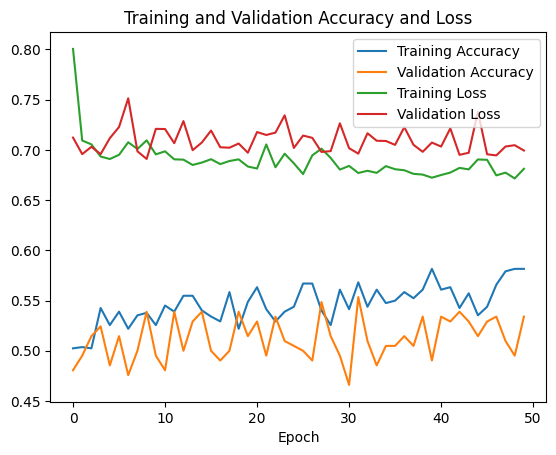

In [59]:
# affichage des courbes d'entrainement et de validation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Accuracy and Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

### __Sauvegarde du modèle__

In [60]:
# sauvegarde du modele
pickle.dump(model, open("neural_network.pkl", "wb"))

## C. Random Forest

### __C.1 Creation du modèle__

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import json
from sklearn.datasets import make_classification
from sklearn.tree import plot_tree
import pickle
from sklearn.metrics import f1_score

In [6]:
# importation des données utilisateur
with open('user.json', 'r') as f:
    user_data = json.load(f)

# creation des label encoder
le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()
le5 = LabelEncoder()
le6 = LabelEncoder()

In [7]:
# creation des dataframes
data = user_data["data"]
result = user_data["result"]
dataframe = pd.DataFrame(data, columns=["Type 1", "Type 2", "Generation","legendary", "color"])
resultframe = pd.DataFrame(result, columns=["favorite"])

# encoding des données
dataframe["Type 1"] = le1.fit_transform(dataframe["Type 1"])
dataframe["Type 2"] = le2.fit_transform(dataframe["Type 2"])
dataframe["Generation"] = le3.fit_transform(dataframe["Generation"])
dataframe["legendary"] = le4.fit_transform(dataframe["legendary"])
dataframe["color"] = le5.fit_transform(dataframe["color"])
resultframe["favorite"] = le6.fit_transform(resultframe["favorite"])

# Separe les données en données d'entrainement et de test
train_data = dataframe.sample(frac=0.8, random_state=0)
test_data = dataframe.drop(train_data.index)

# Separe les labels en labels d'entrainement et de test
train_labels = resultframe.sample(frac=0.8, random_state=0)
test_labels = resultframe.drop(train_labels.index)

# Definie le modele
model = RandomForestClassifier(n_estimators=5, random_state=0)

# entrainement du modele
model.fit(train_data, train_labels)

C:\Users\Tototime\AppData\Local\Temp\ipykernel_128520\94842673.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(train_data, train_labels)


RandomForestClassifier(n_estimators=5, random_state=0)

### __C.2 Visualisation du modèle__

[Text(0.23207677817153494, 0.9722222222222222, 'x[1] <= 3.5\ngini = 0.498\nsamples = 526\nvalue = [434, 388]'),
 Text(0.018327605956471937, 0.9166666666666666, 'x[2] <= 3.5\ngini = 0.388\nsamples = 12\nvalue = [5, 14]'),
 Text(0.013745704467353952, 0.8611111111111112, 'x[0] <= 7.5\ngini = 0.473\nsamples = 9\nvalue = [5, 8]'),
 Text(0.009163802978235968, 0.8055555555555556, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.018327605956471937, 0.8055555555555556, 'x[0] <= 11.5\ngini = 0.397\nsamples = 7\nvalue = [3, 8]'),
 Text(0.013745704467353952, 0.75, 'x[4] <= 5.0\ngini = 0.444\nsamples = 6\nvalue = [3, 6]'),
 Text(0.009163802978235968, 0.6944444444444444, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.018327605956471937, 0.6944444444444444, 'x[1] <= 1.5\ngini = 0.375\nsamples = 5\nvalue = [2, 6]'),
 Text(0.009163802978235968, 0.6388888888888888, 'x[4] <= 21.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.004581901489117984, 0.5833333333333334, 'gini = 0.0\nsamples = 1\n

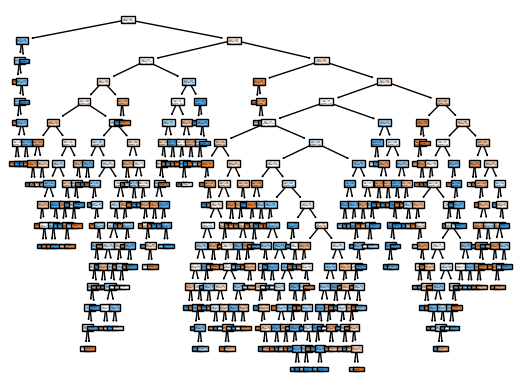

In [64]:
plot_tree(model.estimators_[0], filled=True)

[Text(0.44356446582412223, 0.975, 'x[2] <= 2.5\ngini = 0.499\nsamples = 444\nvalue = [336, 372]'),
 Text(0.2206599479843953, 0.925, 'x[1] <= 17.5\ngini = 0.5\nsamples = 223\nvalue = [181, 173]'),
 Text(0.09850455136540963, 0.875, 'x[0] <= 9.5\ngini = 0.465\nsamples = 85\nvalue = [81, 47]'),
 Text(0.04681404421326398, 0.825, 'x[1] <= 9.5\ngini = 0.5\nsamples = 39\nvalue = [27, 27]'),
 Text(0.02080624187256177, 0.775, 'x[4] <= 22.5\ngini = 0.388\nsamples = 13\nvalue = [5, 14]'),
 Text(0.010403120936280884, 0.725, 'x[1] <= 3.5\ngini = 0.32\nsamples = 10\nvalue = [3, 12]'),
 Text(0.005201560468140442, 0.675, 'gini = 0.0\nsamples = 2\nvalue = [0, 4]'),
 Text(0.015604681404421327, 0.675, 'x[4] <= 17.5\ngini = 0.397\nsamples = 8\nvalue = [3, 8]'),
 Text(0.010403120936280884, 0.625, 'x[1] <= 6.0\ngini = 0.5\nsamples = 5\nvalue = [3, 3]'),
 Text(0.005201560468140442, 0.575, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.015604681404421327, 0.575, 'x[0] <= 1.5\ngini = 0.48\nsamples = 4\nval

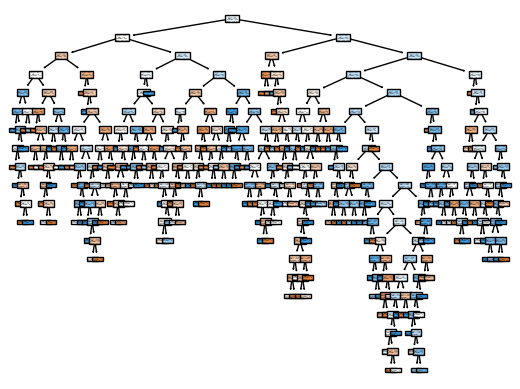

In [ ]:
plot_tree(model.estimators_[1], filled=True)

[Text(0.5462399746509309, 0.9761904761904762, 'x[2] <= 4.5\ngini = 0.5\nsamples = 465\nvalue = [354, 354]'),
 Text(0.1862299493018617, 0.9285714285714286, 'x[1] <= 3.5\ngini = 0.5\nsamples = 409\nvalue = [318, 301]'),
 Text(0.026595744680851064, 0.8809523809523809, 'x[4] <= 14.5\ngini = 0.485\nsamples = 20\nvalue = [12, 17]'),
 Text(0.02127659574468085, 0.8333333333333334, 'x[4] <= 9.5\ngini = 0.499\nsamples = 18\nvalue = [12, 13]'),
 Text(0.015957446808510637, 0.7857142857142857, 'gini = 0.0\nsamples = 2\nvalue = [0, 3]'),
 Text(0.026595744680851064, 0.7857142857142857, 'x[2] <= 3.5\ngini = 0.496\nsamples = 16\nvalue = [12, 10]'),
 Text(0.02127659574468085, 0.7380952380952381, 'x[4] <= 10.5\ngini = 0.444\nsamples = 12\nvalue = [12, 6]'),
 Text(0.010638297872340425, 0.6904761904761905, 'x[0] <= 9.5\ngini = 0.42\nsamples = 7\nvalue = [7, 3]'),
 Text(0.005319148936170213, 0.6428571428571429, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.015957446808510637, 0.6428571428571429, 'x[2]

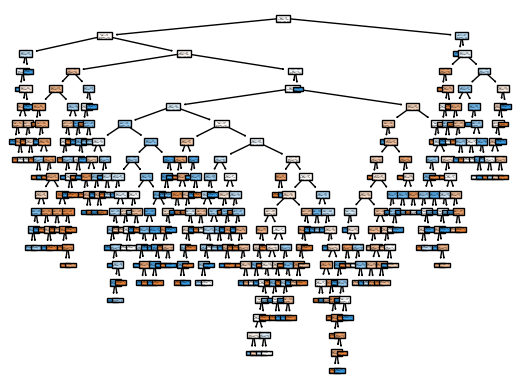

In [ ]:
plot_tree(model.estimators_[4], filled=True)

### __C.3 Evaluation du modèle__

In [8]:
# Evaluation du modele
y_pred = model.predict(train_data)
print("Accuracy:", accuracy_score(train_labels, y_pred))

# score F1 du modele
print("F1 score:", f1_score(train_labels, y_pred, average='macro'))

Accuracy: 0.8114355231143552
F1 score: 0.8114218475952252


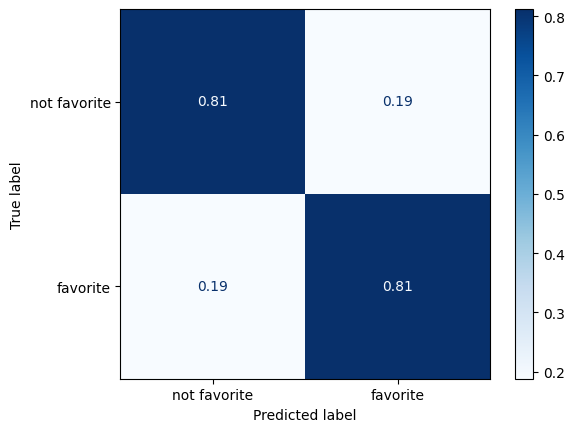

In [66]:
# afficher la matrice de confusion
cm = confusion_matrix(train_labels, y_pred, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not favorite', 'favorite'])
disp.plot(cmap='Blues')
plt.show()

### __Sauvegarde du modèle__

In [67]:
# sauvegarder le modèle
pickle.dump(model, open("random_forest.pkl", "wb"))

## Syteme de recommandation

In [1]:
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
import pickle
import json
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [12]:
with open("database.json") as f:
    data2 = json.load(f)

print(type(data2['1.jpg']['tags']['Legendary']))


<class 'bool'>


In [2]:
def visualisation(tag,value_tag):
    # Charger les données à partir du fichier JSON
    with open("database.json") as f:
        data = json.load(f)
    # Convertir le dictionnaire en DataFrame
    df = pd.DataFrame.from_dict(data, orient='index')

    # Concaténer les colonnes "tags" en tant que colonnes séparées
    df = pd.concat([df.drop('tags', axis=1), df['tags'].apply(pd.Series)], axis=1)

    # Grouper les données par la valeur de la colonne "tag"
    grouped = df.groupby(tag)

    # Afficher le nombre d'images par valeur de la colonne "tag"
    ax=grouped.size().plot(kind="bar", title=f"Nombre d'images par {tag}")
    # Afficher la valeur du tag par la couleur jaune
    for i, label in enumerate(ax.get_xticklabels()):
        if label.get_text() == value_tag:
            ax.patches[i].set_color('yellow')

In [27]:
def recommend_pokemon():
    satisfait = False # Variable de controle de la boucle

    # import data
    with open('database.json', 'r') as f:
        data = json.load(f)

    with open('recommendation.json', 'r') as f:
        rec= json.load(f)

    # importation des modèles
    random_forest = pickle.load(open("random_forest.pkl", "rb"))
    neural_network = pickle.load(open("neural_network.pkl", "rb"))
    decision_tree = pickle.load(open("decision_tree.pkl", "rb"))

    # creation des label encoder
    le1 = LabelEncoder()
    le2 = LabelEncoder()
    le3 = LabelEncoder()
    le4 = LabelEncoder()
    le5 = LabelEncoder()

    recommandations = []
    

    while not satisfait:

        #interface utilisateur
        print("Bonjour, je suis un Assistant Pokémon, je vais vous aider à choisir votre prochain Pokemon")
        type1=input("Quel est le type 1 que vous aimez le plus : " + str(rec["Type"]) + " ? ")
        type2=input("Quel est le type 2 que vous aimez le plus : " + str(rec["Type"]) + " ? ")
        generation=int(input("Quel est la generation de  Pokemon que vous aimez le plus: 1,2,3,4,5,6 ? "))
        legendary=input("Aimez vous les pokemons légendaires (True/False) ? ")
        couleur=input("Quelle est la couleur favorite parmis ceux-ci : " + str(rec["Color"]) + " ? ")

        # Créer un dataframe pour le nouveau Pokémon
        pokemon = pd.DataFrame([[type1, type2, generation, legendary, couleur]], columns=["Type 1", "Type 2", "Generation","legendary", "color"])

        # Encoder les données
        pokemon["Type 1"] = le1.fit_transform(pokemon["Type 1"])
        pokemon["Type 2"] = le2.fit_transform(pokemon["Type 2"])
        pokemon["Generation"] = le3.fit_transform(pokemon["Generation"])
        pokemon["legendary"] = le4.fit_transform(pokemon["legendary"])
        pokemon["color"] = le5.fit_transform(pokemon["color"])
            
        # Prédire si le Pokémon sera favori ou non
        prediction1 = random_forest.predict(pokemon)
        prediction2 = neural_network.predict(pokemon)
        prediction3 = decision_tree.predict(pokemon)

        # Si 2 des 3 modèles prédit que le Pokémon sera favori, alors le Pokémon sera favori
        if (prediction1[0] == 0 or prediction2[0][0] >= 0.6 or prediction3[0] == 0):
            print("Le Pokémon sera favori")

            # Ajouter les pokémons recommandés à recommandations
            if legendary == "False":
                for pokemon_data in data.values():
                    if pokemon_data['tags']["Legendary"] == False:
                        if (pokemon_data["couleur dominante"] == couleur and
                            ((pokemon_data["tags"]["Type 1"] == type1 or
                            pokemon_data["tags"]["Type 2"] == type2) or
                            (pokemon_data["tags"]["Type 1"] == type2 or
                            pokemon_data["tags"]["Type 2"] == type1)) and
                            pokemon_data["tags"]["Generation"] == generation):
                            recommandations.append(pokemon_data)
            else:
                for pokemon_data in data.values():
                    if pokemon_data['tags']["Legendary"] == True:
                        if (pokemon_data["couleur dominante"] == couleur and
                            pokemon_data["tags"]["Generation"] == generation):
                            recommandations.append(pokemon_data)
                    
            satisfait = True
        else:
            # Sinon, recommencer
            print("Le Pokémon ne sera pas favori")
            satisfait = False


    # Afficher les pokémons recommandés
    print("Voici les pokémons recommandés:")
    if recommandations==[]:
        print("Aucun pokémon ne correspond à vos critères")
    else:
        for pokemon in recommandations:
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            img = Image.open("./pokemon_jpg/pokemon_jpg/" + str(pokemon['id']) + ".jpg")

            if pokemon["tags"]["Type 2"] == None:
                text = "Nom: " + pokemon["tags"]["Name"] + "\nType 1: " + pokemon["tags"]["Type 1"] + "\nGeneration: " + str(pokemon["tags"]["Generation"]) + "\nLegendary: " + str(pokemon["tags"]["Legendary"]) + "\nCouleur dominante: " + pokemon["couleur dominante"]
            else:
                text = "Nom: " + pokemon["tags"]["Name"] + "\nType 1: " + pokemon["tags"]["Type 1"] + "\nType 2: " + pokemon["tags"]["Type 2"] + "\nGeneration: " + str(pokemon["tags"]["Generation"]) + "\nLegendary: " + str(pokemon["tags"]["Legendary"]) + "\nCouleur dominante: " + pokemon["couleur dominante"]
            axes[0].imshow(img)
            axes[1].text(0.5, 0.5,text,fontsize=14, ha='center', va='center')
            axes[0].axis('off')
            axes[1].axis('off')
            plt.show()

            visualisation("Type 1",pokemon["tags"]["Type 1"])
            plt.show()
            if pokemon["tags"]["Type 2"] != None:
                visualisation("Type 2",pokemon["tags"]["Type 2"])
                plt.show()
            visualisation("Generation",str(pokemon["tags"]["Generation"]))
            plt.show()
            visualisation("couleur dominante",pokemon["couleur dominante"])
            plt.show()
            

## Visualisation des données

Bonjour, je suis un assistant Pokemon, je vais vous aider à choisir votre prochain Pokemon
1/1 [==============================] - 0s 90ms/step
Le Pokémon sera favori
Voici les pokémons recommandés:


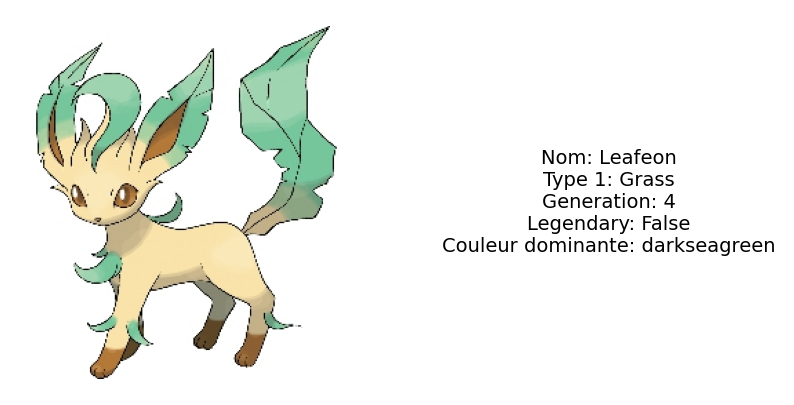

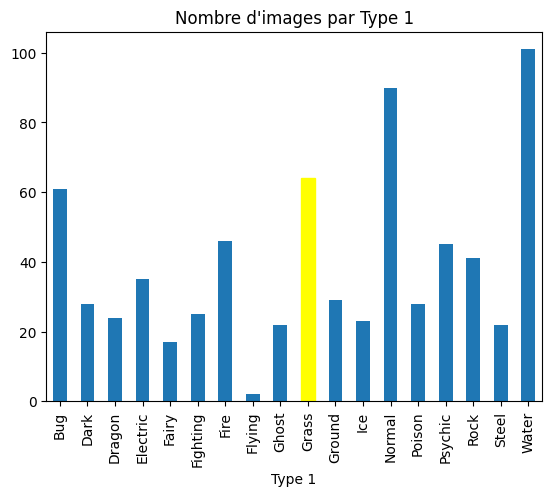

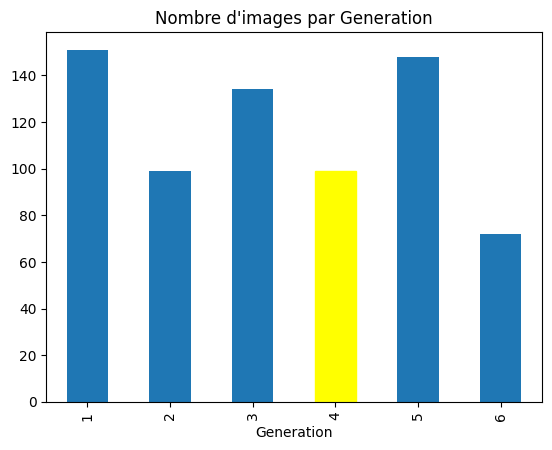

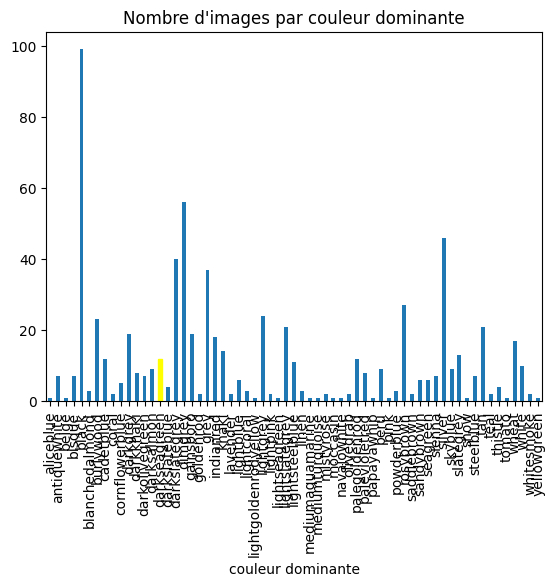

In [29]:
recommend_pokemon()

## Tests

In [2]:
import pickle
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import LabelEncoder

In [3]:
#label encoder
le1 = LabelEncoder()
le2 = LabelEncoder()
le3 = LabelEncoder()
le4 = LabelEncoder()
le5 = LabelEncoder()

In [4]:
# Test des 3 modèles
pikachu={"Type 1":"Electric","Type 2":"None","Generation":1,"legendary":False,"color":"khaki"}
Bulbasaur={"Type 1":"Grass","Type 2":"Poison","Generation":1,"legendary":False,"color":"darkseagreen"}
Mewtwo={"Type 1":"Psychic","Type 2":"None","Generation":1,"legendary":True,"color":"gainsboro"}

# Créer un dataframe pour le nouveau Pokémon
pokemon = pd.DataFrame([pikachu], columns=["Type 1", "Type 2", "Generation","legendary", "color"])
pokemon2 = pd.DataFrame([Bulbasaur], columns=["Type 1", "Type 2", "Generation","legendary", "color"])
pokemon3 = pd.DataFrame([Mewtwo], columns=["Type 1", "Type 2", "Generation","legendary", "color"])

# Encoder les données
pokemon["Type 1"] = le1.fit_transform(pokemon["Type 1"])
pokemon["Type 2"] = le2.fit_transform(pokemon["Type 2"])
pokemon["Generation"] = le3.fit_transform(pokemon["Generation"])
pokemon["legendary"] = le4.fit_transform(pokemon["legendary"])
pokemon["color"] = le5.fit_transform(pokemon["color"])

pokemon2["Type 1"] = le1.fit_transform(pokemon2["Type 1"])
pokemon2["Type 2"] = le2.fit_transform(pokemon2["Type 2"])
pokemon2["Generation"] = le3.fit_transform(pokemon2["Generation"])
pokemon2["legendary"] = le4.fit_transform(pokemon2["legendary"])
pokemon2["color"] = le5.fit_transform(pokemon2["color"])

pokemon3["Type 1"] = le1.fit_transform(pokemon3["Type 1"])
pokemon3["Type 2"] = le2.fit_transform(pokemon3["Type 2"])
pokemon3["Generation"] = le3.fit_transform(pokemon3["Generation"])
pokemon3["legendary"] = le4.fit_transform(pokemon3["legendary"])
pokemon3["color"] = le5.fit_transform(pokemon3["color"])


# importation des modèles
random_forest = pickle.load(open("random_forest.pkl", "rb"))
neural_network = pickle.load(open("neural_network.pkl", "rb"))
decision_tree = pickle.load(open("decision_tree.pkl", "rb"))

# Prédire si le Pokémon sera favori ou non
prediction1 = random_forest.predict(pokemon)
prediction2 = neural_network.predict(pokemon)
prediction3 = decision_tree.predict(pokemon)

prediction4 = random_forest.predict(pokemon2)
prediction5 = neural_network.predict(pokemon2)
prediction6 = decision_tree.predict(pokemon2)

prediction7 = random_forest.predict(pokemon3)
prediction8 = neural_network.predict(pokemon3)
prediction9 = decision_tree.predict(pokemon3)


# Afficher la prédiction
print("Prédiction pour Pikachu:")
if prediction1[0]==0 :
    print("d'apres le random forest le Pokémon sera favori")
else:
    print("d'apres le random forest le Pokémon ne sera pas favori")
  
if prediction2[0][0] >= 0.6 :
    print("d'apres le neural network le Pokémon sera favori")
else:
    print("d'apres le neural network le Pokémon ne sera pas favori")

if prediction3[0]==0 :
    print("d'apres le decision tree le Pokémon sera favori")
else:
    print("d'apres le decision tree le Pokémon ne sera pas favori")

print("Prédiction pour Bulbasaur:")
if prediction4[0]==0 :
    print("d'apres le random forest le Pokémon sera favori")
else:
    print("d'apres le random forest le Pokémon ne sera pas favori")

if prediction5[0][0] >= 0.6 :
    print("d'apres le neural network le Pokémon sera favori")
else:
    print("d'apres le neural network le Pokémon ne sera pas favori")

if prediction6[0]==0 :
    print("d'apres le decision tree le Pokémon sera favori")
else:
    print("d'apres le decision tree le Pokémon ne sera pas favori")

print("Prédiction pour Mewtwo:")
if prediction7[0]==0 :
    print("d'apres le random forest le Pokémon sera favori")
else:
    print("d'apres le random forest le Pokémon ne sera pas favori")

if prediction8[0][0] >= 0.6 :
    print("d'apres le neural network le Pokémon sera favori")
else:
    print("d'apres le neural network le Pokémon ne sera pas favori")

if prediction9[0]==0 :
    print("d'apres le decision tree le Pokémon sera favori")
else:
    print("d'apres le decision tree le Pokémon ne sera pas favori")

1/1 [==============================] - 0s 42ms/step
Prédiction pour Pikachu:
d'apres le random forest le Pokémon sera favori
d'apres le neural network le Pokémon ne sera pas favori
d'apres le decision tree le Pokémon sera favori
Prédiction pour Bulbasaur:
d'apres le random forest le Pokémon sera favori
d'apres le neural network le Pokémon ne sera pas favori
d'apres le decision tree le Pokémon sera favori
Prédiction pour Mewtwo:
d'apres le random forest le Pokémon sera favori
d'apres le neural network le Pokémon ne sera pas favori
d'apres le decision tree le Pokémon sera favori
